# Vehicle Detection and Tracking Project

In this project, my goal was to write a software pipeline to detect vehicles in a video (starting first with the test_video.mp4 and later implement on full project_video.mp4); the pipeline is presented in detail in writeup of the project.

The project has three main steps:
- Histogram of Oriented Gradients (HOG)  
    - we have been provided with a set of images: 8968 various traffic images, 8792 images with cars;images are color, 64x64 pixels  
    - using HOG and other techniques, extract features of these images  
    - separate the images in train/test and train a SVM classifier  
- Sliding Window Search  
    - implemented a sliding window search and classify each window as vehicle or non-vehicle  
    - run the function first on test images and afterwards against project video 
- Video Implementation  
    - output a video with the detected vehicles positions drawn as bounding boxes  
    - implement a robust method to avoid false positives (could be a heat map showing the location of repeat detections)

In the end the results are interpreted and discussed.

## Histogram of Oriented Gradients (HOG)

In [1]:
# importing relevant modules

# numerical modules
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

# system modules
import glob
import time

# computer vision modules
import cv2
from skimage.feature import hog
from skimage import color, exposure

# machine learning modules
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# video processing modules
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed

In [2]:
# on my local drive, all images are place in the same location named dataset
# all vehicle images start with the string "car"
# all nonvehicle images start with the string "traffic"

# images are divided up into vehicles and non-vehicles
images = glob.glob('./dataset/*.png')
cars = []
notcars = []

for image in images:
    if 'traffic' in image:
        notcars.append(image)
    else:
        cars.append(image)

In [3]:
# check if all images have been collected
# no of vehicle images = 8792, no of traffic images = 8968
len(cars), len(notcars)

(8792, 8968)

In [4]:
# define a function to return HOG features and visualization
# as we already saw how this function work, don't need visualisation
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # otherwise call with one output; this will increase speed if we don't want to visualise
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
# define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [6]:
# define a function to compute color histogram features 
# bins_range must be (0, 1) if reading .png files with mpimg
# bins_range must be (0, 255) if reading .png files with cv2
# bins_range must be (0, 255) if reading .jpg files with mpimg

def color_hist(img, nbins=32, bins_range=(0, 1)):
    # compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
# define a function to extract features from a list of images
# this function calls bin_spatial(), color_hist() and get_hog_features() created earlier

# this function is used to extract feature that will be used to train the classification model
# this function will create a combination of hog, spatial and color features; the result will be used in training the classifier

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # create a list to append feature vectors to
    features = []
    
    # iterate through the list of images
    for file in imgs:
        file_features = []
        # read in each image one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            # if a specific color space is called, we gi ahead with an image transformed in that color space
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image) # if color space is RGB we go ahead with a copy of the image  

        if spatial_feat == True:
            # call bin_spatial()
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            # call color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
        # now go to next image
    
    # Return list of feature vectors
    return features

In [8]:
# parameters used to extract HOG features
# these parameters were obtained through trial and error to give the highest accuracy
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 700] # Min and max in y to search in slide_window()

In [9]:
# extract features of images in vehicle set and non-vehicle set
# measuring time is not that relevant
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

122.49 Seconds to extract HOG features...


In [10]:
# in the above cell we extract the features separately in order to keep the two set separately

In [11]:
# create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# define the labels vector, applyinng a value of one for features that have vehicles
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# we can apply a truely random state, but I prefer to keep a control on the randomness and be able to re-produce the results
rand_state = 23
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [12]:
# fit a per-column scaler on the train data and apply it to normalize both train and test data
# ! we don't fit on the test to avoit overfitting 
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [13]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7284


In [14]:
# Use a linear SVC to train the classifier, cont the time to train and plot the accuracy in the test data set
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample

20.51 Seconds to train SVC...
Test Accuracy of SVC =  0.9851


In [15]:
# Do a prediction on the first 20 images in test (remember these are already randomized)
t=time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
For these 20 labels:  [0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
0.00902 Seconds to predict 20 labels with SVC


In [16]:
# after this cell we have classifier trained
# we should not go ahead until our classifier retruns a good enough accuracy, more than 95%

## Sliding Window Search

In [17]:
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions) and overlap fraction (for both x and y)

# and returns a list of windows that will be scaned

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # if x and/or y start/stop positions not defined, set to image size
    # these values define the limits of the windows search
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # initialize a list to append window positions to
    window_list = []
    
    # loop through the number of windows and compute x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # return the list of windows
    return window_list

In [18]:
# define a function to draw bounding boxes on an image img and given a list of corner coordinates of the boxes
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return imcopy

In [19]:
# define a function to extract features from a single image window
# this function is very similar to extract_features() just for a single image rather than list of images
# this will be used to extract the features of each frame in a video
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) define an empty list to receive features
    img_features = []
    
    #2) apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    #3) compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    
    #5) compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    
    #7) compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) append features to list
        img_features.append(hog_features)

    #9) return concatenated array of features
    return np.concatenate(img_features)

In [20]:
# define a function you will pass an image and the list of windows to be searched (output of slide_windows())
# the function will use a classifier to check of the given window contains the features of a car
# if answer is yes, the window is passed a long and all positive windows are returned
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        
        #3) Extract the test window from original image and resize to the train images dimension
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))     
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier trained above
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    #8) Return windows for positive detections
    return on_windows

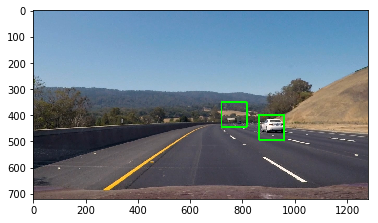

In [21]:
# test the pipeline on a test image

# start the clock to measure how long it takes
t=time.time()

# read in a test image
image = mpimg.imread('./test_images/test3.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)                    

plt.imshow(window_img)

In [ ]:
# the test image show a few false positives; the code in this cell sugest how to remov these false positives
from scipy.ndimage.measurements import label
box_list = hot_windows
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Video Implementation

In [26]:
# based on all functions ran above we can create a pipeline function to process video frames
def analyze_frame(image):
    draw_image = np.copy(image)

    image = image.astype(np.float32)/255

    windows = slide_window(image,x_start_stop=[None, None],y_start_stop=y_start_stop,xy_window=(96,96),xy_overlap=(0.5,0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    return window_img

In [27]:
# test video
video_output1 = 'test_video_output.mp4'
video_input1 = VideoFileClip('test_video.mp4')
processed_video = video_input1.fl_image(analyze_frame)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:26<00:02,  2.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 1min 26s


In [ ]:
# project video is realy long and its processing takes a long time
# we will go ahed with this only after we have a good enough test_video_output

# project video
video_output2 = 'project_video_output.mp4'
video_input2 = VideoFileClip('project_video.mp4')
processed_video = video_input2.fl_image(analyze_frame)
%time processed_video.write_videofile(video_output2, audio=False)